In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiLabelsMasker
from scipy.stats import pearsonr

/home/harveyaa/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# **Downstream Analyses**
In this tutorial we'll use a real dataset to demonstrate using a held out training set in order not to use the results of the normative model for downstream analyses.


## **Download and Process Data**
In both examples we'll use the Cobre dataset. The Cobre dataset consists of resting state fMRI scans for 146 subjects which are either controls or patients diagnosed with Schizophrenia. Here we'll use `nilearn` to fetch the data and process it into connectomes, which are correlation matrices that capture how similar each pair of brain regions are in terms of their functional activity, and for demonstration purposes we'll choose an arbitrary edge from the connectome to fit our normative models to.

First, we'll use nilearn to fetch the data. Running the cell below will download ~700 MB of data to your machine.

In [2]:
# Download the dataset
cobre = datasets.fetch_cobre(n_subjects=None)

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fetch_cobre is deprecated; 'fetch_cobre' has been deprecated and will be removed in release 0.9 . Please consider using a different datasets or downloading it with a different tool than nilearn.
  warnings.warn(msg, category=FutureWarning)
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Now that we have our data, we will need to process it from functional scans (4D data) into connectomes for each subject. To do that we need to download an atlas (to divide the brain into regions) and create `nilearn` objects to extract the activity from each region (`NiftiLabelsMasker`) and to compare the activity between regions (`ConnectivityMeasure`). 

Running this cell takes about a minute to process each connectome and downloads an atlas (~30MB). 

**Note:** 
We've sorted the `cobre.func` and `cobre.confounds` list of filenames to ensure that we are using the same ordering of subjects everywhere (ranked increasing by ID number).

In [3]:
# Download an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Create the masker and correlation measure
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Get a connectome for each subject
mask = np.tril(np.ones((48,48),dtype=bool))
connectomes=[]
for func,conf in zip(np.sort(cobre.func),np.sort(cobre.confounds)):
    ts = masker.fit_transform(func, confounds=conf)
    corr = correlation_measure.fit_transform([ts])[0]
    connectomes.append(corr[mask])

connectomes = np.array(connectomes)

Now we'll build a DataFrame that we can use with PyNM. We'll grab the IDs, status (patient or control), gender, and age from the Cobre phenotypic information first and sort the values according to ID to match the order we processed the connectomes. Then we'll choose a random edge of the connectome to model for our example and add it to the dataframe.

**Note:**
We are building the DataFrame in this manner to ensure that pandas has the correct `dtype` for each column - if the DataFrame has `object` type for any of the columns it will cause an issue with the GAMLSS model (when the DataFrame is converted to R).

In [32]:
# Create a DataFrame
pheno = pd.DataFrame([int(x) for x in cobre.phenotypic['id']])
pheno['status'] = [(x==b'Patient')*1 for x in cobre.phenotypic['subject_type']]
pheno['gender'] = [(x==b'Female')*1 for x in cobre.phenotypic['gender']]
pheno['age'] = [x for x in cobre.phenotypic['current_age']]

# Sort the values by id (same sorting as above)
pheno.sort_values(0,inplace=True)
pheno.reset_index(inplace=True)

### Filter Edges

In [33]:
n_edges = int(connectomes.shape[1]/10)
corr = []
for i in range(connectomes.shape[1]):

    y = connectomes[:,i]
    x = pheno['status']
    r = pearsonr(x,y)[0]
    corr.append(r)

edges = pd.DataFrame([corr], index = ['r']).transpose()
edges['r_abs'] = edges['r'].abs()
edges.sort_values('r_abs',inplace=True)
edges = edges[edges['r'].notna()]
top_edges = edges[-n_edges:].index.to_list()
edges.loc[top_edges]

if len(top_edges) < n_edges:
    n_edges = len(top_edges)

/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [34]:
edge_names = [f"edge_{i}" for i in top_edges]
df = pd.DataFrame(connectomes[:,top_edges],columns = edge_names)
pheno = pd.concat([pheno,df],axis=1)
pheno

,index,0,status,gender,age,edge_799,edge_298,edge_1137,edge_949,edge_198,...,edge_422,edge_685,edge_120,edge_199,edge_418,edge_998,edge_661,edge_525,edge_800,edge_1043
0,7,40000,1,1,20,-0.257406,0.311796,0.014178,-0.082577,-0.032144,...,0.050365,-0.031606,0.078793,0.199364,0.045594,0.136815,0.380494,0.027837,-0.240047,0.128529
1,44,40001,1,0,27,-0.379473,0.131757,-0.192015,0.052609,-0.074335,...,0.113033,-0.058529,0.029666,0.396826,-0.128370,0.228216,0.252841,0.173624,-0.137793,0.159235
2,3,40002,1,0,19,0.018757,-0.091892,0.008347,-0.460239,0.181708,...,0.002302,-0.130790,-0.142620,0.326010,-0.241200,0.178699,0.328724,0.080340,-0.020750,0.379162
3,47,40003,1,0,28,-0.050563,0.287813,-0.201069,-0.323207,0.116047,...,-0.006863,-0.269834,-0.063885,0.181748,-0.344480,-0.026243,0.348844,0.017518,-0.155395,0.450610
4,132,40004,1,0,55,-0.207924,0.253322,0.175348,-0.118534,0.068798,...,-0.002582,0.162083,-0.135686,0.355672,-0.172744,0.128636,0.604843,-0.213837,-0.101746,0.213996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,127,40143,1,0,52,-0.242938,0.307250,0.209056,-0.107722,-0.124790,...,0.386310,-0.204695,-0.108080,-0.044470,-0.101780,0.249154,0.051066,0.119595,-0.090148,0.253470
142,131,40144,0,0,54,-0.100877,0.108641,-0.033476,-0.246691,-0.007987,...,-0.102610,0.010874,-0.019051,0.188778,0.079524,0.395445,0.315924,-0.001056,-0.169603,0.496715
143,5,40145,1,0,19,-0.070697,0.096311,-0.018311,-0.345511,-0.362690,...,0.118903,0.015522,0.089822,-0.198501,-0.055750,0.274921,0.465342,-0.204806,-0.138312,0.349986
144,83,40146,0,0,39,-0.307545,0.053324,-0.145977,-0.191654,-0.158428,...,-0.080727,-0.071308,-0.034203,0.413233,-0.257446,0.295259,0.570290,0.020929,-0.351848,0.294915


<AxesSubplot:xlabel='age', ylabel='edge_1043'>

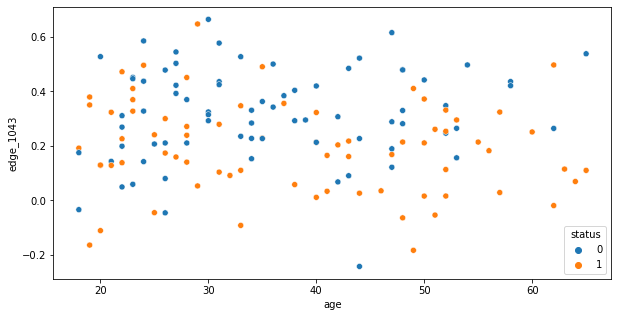

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='edge_1043',data=pheno,hue='status')

## **Example 1**
The wrong way

### Fit Normative Models

In [43]:
%%capture

# Initialize pynm w/ data, confounds & bin parameters
res = []
for i in reversed(range(n_edges)):
    m = PyNM(pheno,edge_names[i],'status',['age','c(gender)'], 
    bin_width=10, bin_spacing=5)
    m.loess_normative_model()
    res.append(m.data['LOESS_z'])
results = pd.concat(res,axis=1)

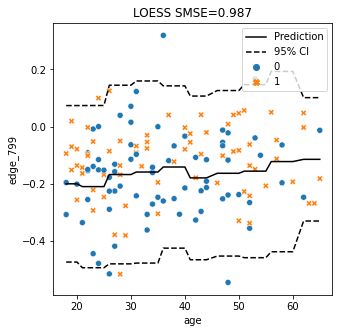

In [44]:
m.plot()

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = results.to_numpy()
y = m.data['status'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

from sklearn.svm import SVC

svr = SVC()
svr.fit(X_train,y_train)
pred = svr.predict(X_test)

print(accuracy_score(y_test,pred))

(97, 117)
(49, 117)
(97,)
(49,)
0.8367346938775511


## **Example 2**
The right way

### Fit Normative Model

In [46]:
%%capture

# Initialize pynm w/ data, confounds & bin parameters
res_clean = []
for i in reversed(range(n_edges)):
    m = PyNM(pheno,edge_names[i],'status',['age','c(gender)'],
            bin_width=10, bin_spacing=5,
            train_sample=0.5, seed=1)
    m.loess_normative_model()
    res_clean.append(m.data[m.data['train_sample']!=1]['LOESS_z'])
results_clean = pd.concat(res_clean,axis=1)
results_clean['status'] = m.data[m.data['train_sample']!=1]['status']

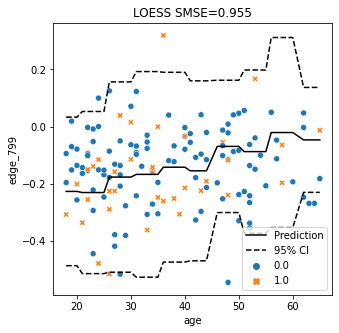

In [47]:
m.plot()

### Use deviance scores for prediction

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = results_clean.to_numpy()
y = results_clean['status'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

from sklearn.svm import SVC

svr = SVC()
svr.fit(X_train,y_train)
pred = svr.predict(X_test)

(73, 118)
(36, 118)
(73,)
(36,)


In [49]:
accuracy_score(y_test,pred)

0.75